<a href="https://colab.research.google.com/github/j-c-stuifbergen/machine-learning-for-physicists/blob/master/07_tutorial_MazePolicyGradient_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning: Using Policy Gradient to solve a Maze

This does not even use a neural network, but instead the policy is stored in an array (table-based policy gradient).

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 7, Tutorial (this is discussed in session 7)

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook is distributed under the Attribution-ShareAlike 4.0 International (CC BY-SA 4.0) license:

https://creativecommons.org/licenses/by-sa/4.0/

This notebook shows how to:
- use policy gradient reinforcement learning to solve a given (fixed) maze (policy gradient based on a table, i.e. state space is sufficiently small)


A little robot is sent through a maze, to collect treasure chests. The maze and the distribution of treasure chests are fixed (i.e. in every trial the robot encounters the same maze). 

Will it be able to find the best strategy?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

# for subplots within subplots:
from matplotlib import gridspec

from IPython.display import clear_output
from time import sleep

## Maze generation algorithm

In [ ]:
# Maze generation algorithm from wikipedia
# the code was removed in January 2020, but you can still
# access it under this link:
# https://en.wikipedia.org/w/index.php?title=Maze_generation_algorithm&oldid=930153705

def maze(width=81, height=51, complexity=.75, density=.75):
    # Only odd shapes
    shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)
    # Adjust complexity and density relative to maze size
    complexity = int(complexity * (5 * (shape[0] + shape[1]))) # number of components
    density    = int(density * ((shape[0] // 2) * (shape[1] // 2))) # size of components
    # Build actual maze
    Z = np.zeros(shape, dtype=bool)
    # Fill borders
    Z[0, :] = Z[-1, :] = 1
    Z[:, 0] = Z[:, -1] = 1
    # Make aisles
    for i in range(density):
        x, y = np.random.randint(0, shape[1] // 2) * 2, np.random.randint(0, shape[0] // 2) * 2 # pick a random position
        Z[y, x] = 1
        for j in range(complexity):
            neighbours = []
            if x > 1:             neighbours.append((y, x - 2))
            if x < shape[1] - 2:  neighbours.append((y, x + 2))
            if y > 1:             neighbours.append((y - 2, x))
            if y < shape[0] - 2:  neighbours.append((y + 2, x))
            if len(neighbours):
                y_,x_ = neighbours[np.random.randint(0, len(neighbours) - 1)]
                if Z[y_, x_] == 0:
                    Z[y_, x_] = 1
                    Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                    x, y = x_, y_
    return Z


In [ ]:
maze(width=5,height=5)

array([[ True,  True,  True,  True,  True],
       [ True, False, False, False,  True],
       [ True,  True,  True, False,  True],
       [ True, False, False, False,  True],
       [ True,  True,  True,  True,  True]])

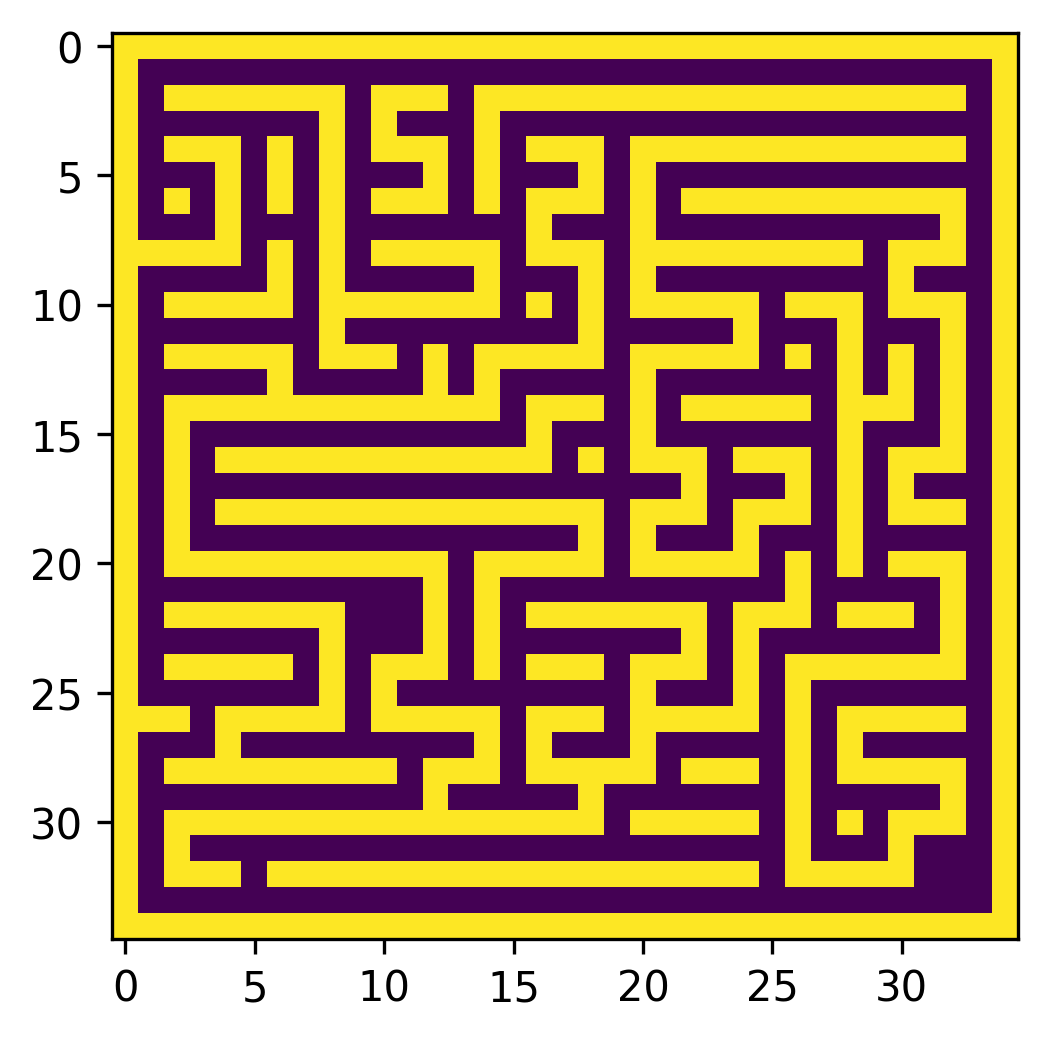

In [ ]:
plt.imshow(maze(width=35,height=35))
plt.show()

## Do a little random walk inside the maze

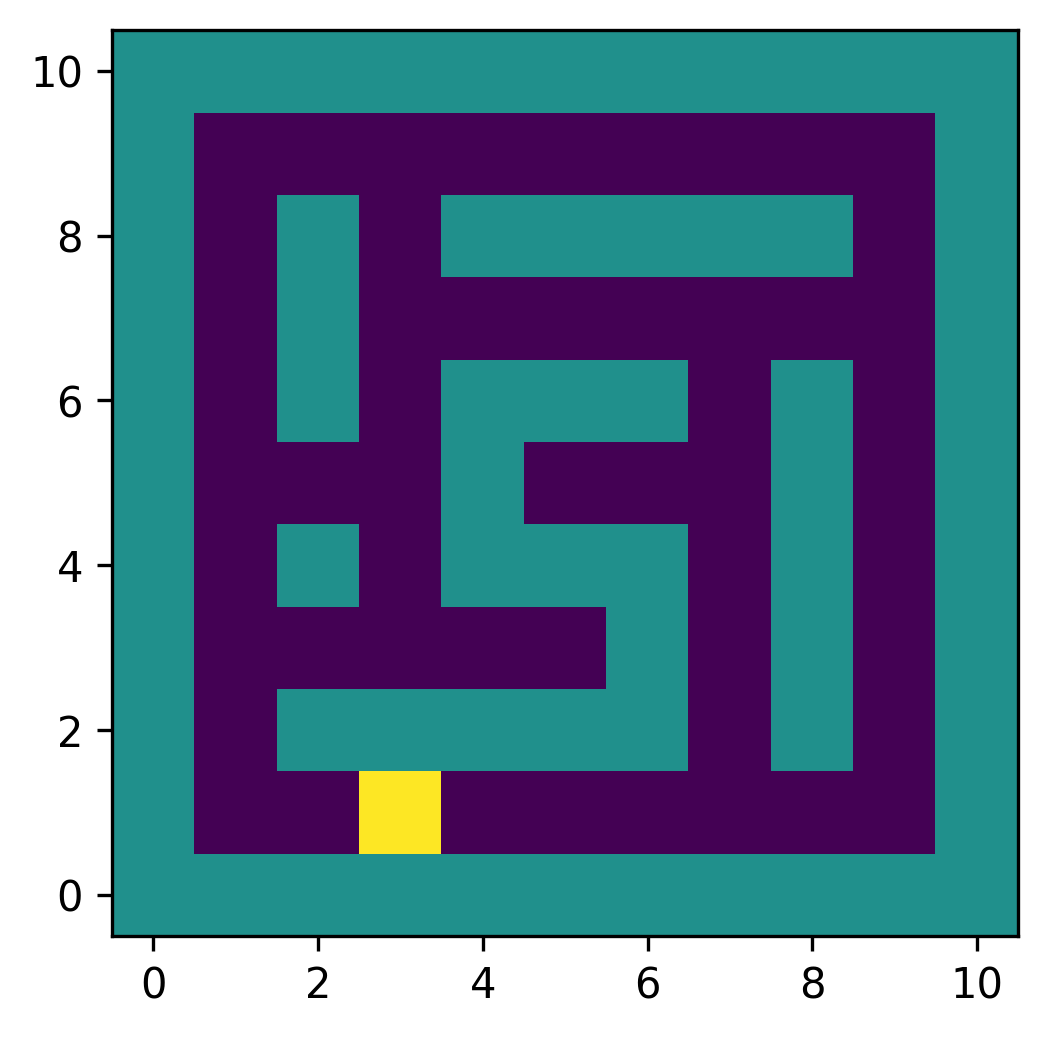

In [ ]:
# make a maze, convert array from True/False to integer:
world=np.array(maze(width=11,height=11),dtype='int')

# the four directions of motion [delta_jx,delta_jy]:
directions=np.array([[0,1],[0,-1],[1,0],[-1,0]])

# initial position
jx,jy=1,1

# take a random walk through the maze and animate this!
nsteps=40
for j in range(nsteps):
    # make a random step
    pick=np.random.randint(4)
    jx_new,jy_new=np.array([jx,jy])+directions[pick]
    if world[jx_new,jy_new]==0: # is empty, can move!
        jx,jy=jx_new,jy_new
        # show what's happening
        picture=np.copy(world) # copy the array (!)
        picture[jx,jy]=2
        plt.imshow(picture,origin='lower')
        plt.show()
        sleep(0.01)
        clear_output(wait=True)

## Now: policy gradient

$$\delta\theta = \eta R \sum_{s,a} {\partial \over \partial \theta} \ln \pi_{\theta}(s,a)$$

Here $\theta$ stands for the parameters controlling the policy probabilities $\pi_{\theta}(s,a)$, s is the state, a the action, and the sum runs over all state-action pairs that were encountered in the given trajectory, which led to an overall return (sum of rewards) R.

Let's do a softmax-type parametrization:

So: $$\theta=(z_0,z_1,z_2,z_3)$$ and

$$\pi_{\theta}(s,a=j) = {e^{z_j} \over \sum_k e^{z_k}} $$

...where in reality the $z_j$ of course also depend on the state s, but for brevity we did not display that dependence here. They will all be stored in arrays, of the size of the maze!

So, we get:

$$ {\partial \over \partial z_l} \ln \pi_{\theta}(s,a=j) = \delta_{l,j}-\pi_{\theta}(s,a=l) $$


In [ ]:
np.cumsum([0.1,0.3,0.4,0.2]) # cumulative sum, will be useful!
# this is useful for drawing integer random numbers according
# to a given arbitrary probability distribution!
# just draw a uniformly distributed number p between 0 and 1 and then
# check successively whether p<(entry of cumsum); stop when
# this is first fulfilled! The index of the entry where you
# stopped will be randomly distributed according to the
# distribution given in the original array.

array([0.1, 0.4, 0.8, 1. ])

## The policy gradient algorithm

In 124 lines of pure python code, including visualization and comments

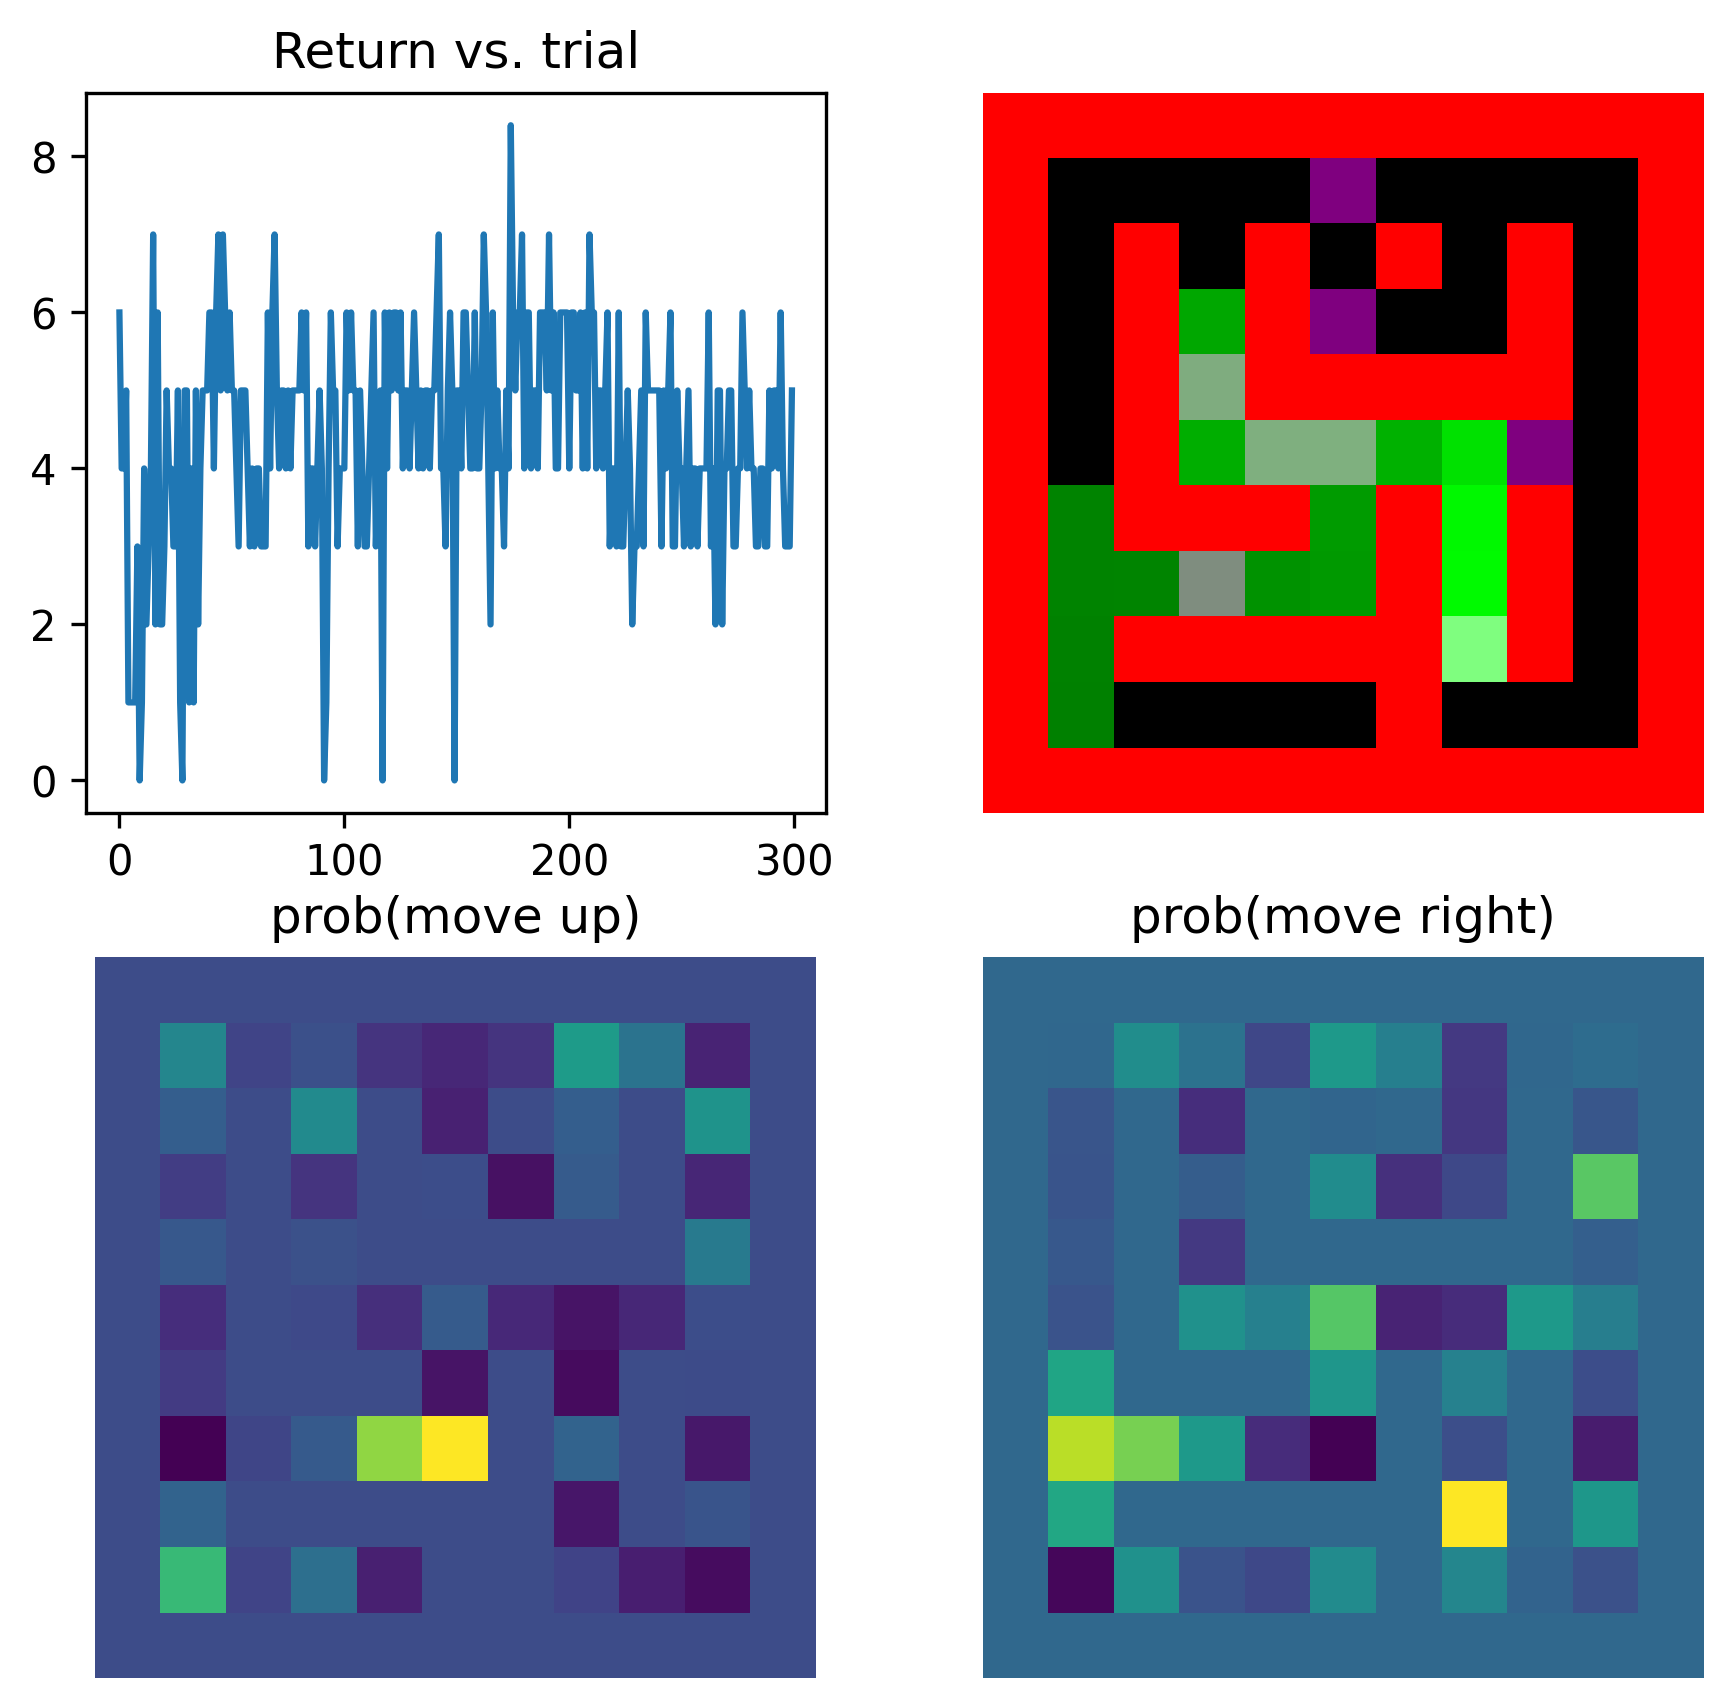

In [ ]:
# full policy gradient RL for picking up 'treasure chests'
# in an automatically generated maze; 2020 by F.M.

M=11 # the size of the world: M x M
eta=0.01 # the learning rate
num_chests=10 # maximum number of treasure chests

# make a maze, convert array from True/False to integer:
world=np.array(maze(width=M,height=M),dtype='int')

# the four directions of motion [delta_jx,delta_jy]:
directions=np.array([[0,1],[0,-1],[1,0],[-1,0]])

# the policy probabilities as an array policy[state,action]
# here the state is represented by two coordinates jx,jy
policy=np.full([M,M,4],0.25)
# and also the underlying 'z'-values for the
# softmax parametrization:
policy_z=np.full([M,M,4],0.0)

# steps inside one trajectory
nsteps=180

# total number of trials, i.e. trajectories
ntrials=300
skipsteps=15 # don't plot every trial

# storing all the state/action pairs of the current trajectory
states=np.zeros([nsteps,2], dtype='int')
actions=np.zeros(nsteps, dtype='int')

# a map of rewards (the 'boxes' are here!)
reward=np.zeros([M,M])
# if too high, there is not enough difference between good and bad trajectories
# if too low, it is unlikely to find a good trajectory
nRewardOriginal = 8
# When all treasures have been found, this is the bonus for the remaining time
speedBonus = 0.2 # this bonus is rarely obtained
# storing all the returns, for all trials:
Returns=np.zeros(ntrials)

# try random selection of reward sites (treasure chests)
for n in range(nRewardOriginal):
  found=False 
  while (False == found):
    jx_target,jy_target=np.random.randint(2,M,size=2)
    # if jx_target>4 or jy_target>4: # stay away from starting point!
    if world[jx_target,jy_target]==0: # empty, keep it!
            reward[jx_target,jy_target]+=1
            found = True
rewardOriginal = reward.copy()
    

# try many trajectories:
for trial in range(ntrials):
    reward = rewardOriginal.copy()
    nReward = nRewardOriginal
    # set return to zero for this trajectory:
    R=0
    # initial position:
    jx,jy=1,1
    
    # go through all time steps
    for t in range(nsteps):
        # make a random step, according to the policy distribution
        p=np.random.uniform()
        cumulative_distribution=np.cumsum(policy[jx,jy,:])
        for pick in range(4):
            if p<cumulative_distribution[pick]:
                break

        # record the move
        states[t,0]=jx
        states[t,1]=jy
        actions[t]=pick

        # now make the move
        jx_new,jy_new=np.array([jx,jy])+directions[pick]

        # really make it if there is no wall:
        if world[jx_new,jy_new]==0: # is empty, can move!
            jx,jy=jx_new,jy_new
        
        # get a reward if on a treasure chest!
        if 0<reward[jx,jy]:
          R +=reward[jx,jy]
          # then remove the treasure (added by JacoS)
          reward[jx,jy]=0
          # remaining treasures
          nReward -= 1
          
        if 0==nReward:
          R+=speedBonus
   
    # store the return
    Returns[trial]=R
    
    # use policy gradient update rule to adjust
    # probabilities!
    for t in range(nsteps): # go through the trajectory again
        a=actions[t] # remember the action taken at step t
        sx=states[t,0] # state/x-position at step
        sy=states[t,1] # state/y-position
        kronecker=np.zeros(4); kronecker[a]=1.0
        policy_z[sx,sy,:]+=eta*R*(kronecker-policy[sx,sy,:])

    # now calculate (again) the policy probab. from the z-values
    policy=np.exp(policy_z)
    policy/=np.sum(policy,axis=2)[:,:,None] # normalize
    # these two steps together implement softmax on every
    # site! efficient array syntax!
    
    # visualize!
    if trial%skipsteps==0 or trial==ntrials-1:
        # show what's happened in this trajectory
        clear_output(wait=True)
        fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(7,7))
        ax[0,0].plot(Returns) # all the returns, in all trials
        ax[0,0].set_title("Return vs. trial")
        
        picture=np.zeros([M,M,3]) # last index: red/green/blue
        picture[:,:,0]=world # walls are red
        for j in range(nsteps): # highlight trajectory
            picture[states[j,0],states[j,1],1]=0.5*(1.0+(1.0*j)/nsteps)
        # put a bright pixel at the positions visited
        picture[:,:,2]+=0.5*rewardOriginal # highlight the target sites!
        picture[:,:,0]+=0.5*rewardOriginal

        # show picture (transpose is needed because
        # otherwise the first coordinate jx is plotted upwards,
        # not to the right)
        ax[0,1].imshow(np.transpose(picture,[1,0,2]),origin='lower')
        ax[0,1].axis('off')
        
        ax[1,0].imshow(np.transpose(policy[:,:,0]),origin='lower')
        ax[1,0].axis('off')
        ax[1,0].set_title("prob(move up)")
        ax[1,1].imshow(np.transpose(policy[:,:,2]),origin='lower')
        ax[1,1].set_title("prob(move right)")
        ax[1,1].axis('off')
        plt.show()

# Tutorial Exercise: Change the algorithm, such that the treasure chests are 'taken away' by the robot

That is: the reward value at a given site should decrease every time the reward is received (but you need to re-initialize to the old reward map for every new trial!)

Observe how the strategy looks like now!

Attention: don't go to negative rewards! (unless you want to train the robot to avoid places after it picked up a chest there!)

# Tutorial Exercise: Think about other rules of the game!

The only constraint is that the best (or at least a good) strategy can be formulated based only on the position (e.g. wandering ghosts like in PacMan would be a problem for the robot)

# Homework Exercise: Invent a game where the state needs to contain additional information (rather than just the position jx,jy)!

...but in such a way that it can still be handled with a table.

# ideas by JacoS

*   coordinates of the treasures? (i.e. the robot knows in advance where the treasures are)

*   the path that has been taken (which fields already have been checked)

By the way, is the algorithm capable of
* wall detection (the robot remembers its previous position, so it should detect whether a move was possible) 
?

Or does it only remember
* at position (x,y) a move in direction (up, down, right etc.) earned me a higher reward 
?